<a href="https://colab.research.google.com/github/alejandrodgb/fastai/blob/main/clean/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import sys

if 'google.colab' in sys.modules:
    ! [ -e /content ] && pip install -Uqq fastbook
    !pip install nbdev
    
import fastbook
fastbook.setup_book()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Data

In [95]:
# Download sample dataset for MNIST
path = untar_data(URLs.MNIST_SAMPLE)

In [96]:
# Review directory
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [97]:
# Review training folder
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [98]:
# Review digit folder contents
(path/'train/3').ls().sorted()

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [99]:
train_path = path/'train'

In [100]:
# Review a single image
nums = [i.ls().sorted() for i in train_path.ls().sorted()]

In [101]:
im = Image.open(nums[0][0])
im

In [102]:
# Review image values
print(im.shape)
tensor(im)[4:10,4:10]

(28, 28)


tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

# Recognising digits

## Pixel similarity

Finding the average 3/7 by calculating the average value accross all images

In [103]:
# Create a list of all images
nums_lists = [[tensor(Image.open(im)) for im in num] for num in nums]

In [104]:
# Stack all tensors convert to float and normalise.
nums_tensors = [torch.stack(nums_list).float()/255 for nums_list in nums_lists]
[t.shape for t in nums_tensors]

[torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28])]

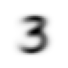

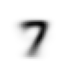

In [105]:
# Find the average digit
mean_digits = [t.mean(0) for t in nums_tensors]
for d in mean_digits:
    show_image(d)

We will test the absolute value of differences (L1 norm) and the root mean squared error (L2 norm as loss functions.

In [106]:
# Sample L1 and L2 norms for a 3 digit against mean 3
L1_3_3 = (nums_tensors[0][1]-mean_digits[0]).abs().mean()
L2_3_3 = ((nums_tensors[0][1]-mean_digits[0])**2).mean().sqrt()
L1_3_3, L2_3_3

(tensor(0.1114), tensor(0.2021))

In [107]:
# Sample L1 and L2 norms for a 3 digit against mean 7
L1_3_7 = (nums_tensors[0][1]-mean_digits[1]).abs().mean()
L2_3_7 = ((nums_tensors[0][1]-mean_digits[1])**2).mean().sqrt()
L1_3_7, L2_3_7

(tensor(0.1586), tensor(0.3021))

These are avaialble in `torch.nn.functional`

In [108]:
(F.l1_loss(nums_tensors[0][1],mean_digits[0]), 
 F.mse_loss(nums_tensors[0][1],mean_digits[0]).sqrt())

(tensor(0.1114), tensor(0.2021))

## Validation set

In [109]:
valid_path = path/'valid'
valid_path.ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [110]:
valid_nums = [i.ls().sorted() for i in valid_path.ls().sorted()]
valid_nums_lists = [[tensor(Image.open(im)) for im in num] for num in valid_nums]
valid_nums_tensors = [torch.stack(nums_list).float()/255 for nums_list in valid_nums_lists]
[t.shape for t in valid_nums_tensors]

[torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28])]

# 